In [15]:
import numpy as np
import pandas as pd
import re
import string

In [16]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

In [17]:
# nltk.download('stopwords')

In [18]:
imdb_df = pd.read_csv('data/final_imdb.csv')

In [19]:
imdb_df = imdb_df[imdb_df['synopsis'] != 'Add a Plot'].dropna(subset=['synopsis']).reset_index(drop=True)

In [20]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [21]:
# Remove punctuation
imdb_df['synopsis'] = imdb_df['synopsis'].map(lambda x: re.sub('[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]', '', x))
# Convert the titles to lowercase
imdb_df['synopsis'] = imdb_df['synopsis'].map(lambda x: x.lower())
# Removing 'see full summary'
imdb_df['synopsis'] = imdb_df['synopsis'].map(lambda x: re.sub('see full summary\xa0»', '', x))
# Print out the first rows of papers
imdb_df['synopsis'] = imdb_df['synopsis'].str.strip()

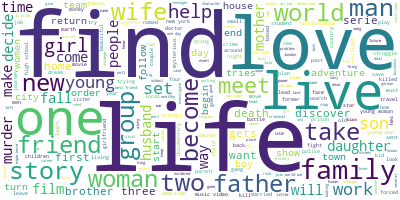

In [22]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(imdb_df['synopsis'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [23]:
imdb_df['synopsis'][17]

'jane langley has always done all she can for her selfish sibling nancy after both sisters fall in love with handsome bill prentice jane graciously steps aside relationships among all'

In [24]:
import gensim
from gensim.utils import simple_preprocess
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]
             
data = imdb_df['synopsis'].values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

[nltk_data] Downloading package stopwords to /home/hem/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['two', 'disturbed', 'young', 'people', 'release', 'fascination', 'guns', 'crime', 'spree']


In [25]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]


In [28]:
from pprint import pprint
# number of topics
num_topics = 2
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.005*"life" + 0.005*"young" + 0.005*"new" + 0.005*"story" + 0.004*"man" + '
  '0.004*"one" + 0.004*"film" + 0.003*"love" + 0.003*"family" + '
  '0.003*"series"'),
 (1,
  '0.008*"young" + 0.006*"two" + 0.005*"life" + 0.005*"man" + 0.005*"love" + '
  '0.005*"one" + 0.005*"family" + 0.004*"woman" + 0.003*"world" + '
  '0.003*"girl"')]


In [29]:
# feed the LDA model into the pyLDAvis instance
lda_viz = gensimvis.prepare(lda_model, corpus, id2word)
lda_viz

/home/hem/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.020676  0.0       1        1  54.830285
0     -0.020676  0.0       2        1  45.169715, topic_info=        Term         Freq        Total Category  logprob  loglift
929   school  2327.000000  2327.000000  Default  30.0000  30.0000
5596   video  1343.000000  1343.000000  Default  29.0000  29.0000
664     film  3072.000000  3072.000000  Default  28.0000  28.0000
161      new  4613.000000  4613.000000  Default  27.0000  27.0000
533    finds  2429.000000  2429.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
805    group  1029.524539  2616.571769   Topic2  -6.2864  -0.1380
116     find  1079.087988  3019.243668   Topic2  -6.2394  -0.2341
691    three  1007.444742  2634.537495   Topic2  -6.3081  -0.1665
214     girl  1015.791631  3198.074094   Topic2  -6.2999  -0.3521
152      war   944.883194  2574.280421   Topic2  -6.3722  -0.2075

[229 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
18249      1  0.057988      abby
18249      2  0.927815      abby
72         1  0.301201  accident
72         2  0.698982  accident
9397       1  0.955488  adorable
...      ...       ...       ...
1645       2  0.587423     years
874        1  0.394966      york
874        2  0.605206      york
8          1  0.658458     young
8          2  0.341549     young

[360 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/